Learn the inter-grid prolongation operator (P) for single-phase problems using multigrid framework,
* Dataset is constructed by changing RHS & Dirichlet boundary conditions
* Restriction and Prolongation kernels are assumed to be the same (3x3)
* Learn the kernel for a single phase Poisson problem

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision.transforms import ToTensor

import os
import scipy.io as sio
import numpy as np
import matplotlib.pyplot as plt
import math
import random

from FEANet.mesh import MeshSquare
from FEANet.geo import Geometry
from FEANet.jacobi import JacobiBlock
from FEANet.model import KNet, FNet

from Utils import plot
from Data.dataset import IsoPoissonDataSet

In [2]:
class SingleGrid():
    '''
    Perform weighted Jacobi iteration relaxation for a single grid.
    Note: the n should be the number of intervals, e.g., 
          there are (n+1)*(n+1) grid points in total if the size is n
          f has already been convoluted, i.e., f = fnet(ff) if ff is the sourcing term of PDE
    '''
    def __init__(self, size, n):
        self.size = size # actual size of the plate
        self.n = n 
        self.omega = 2/3.
        self.plate = Geometry(nnode_edge = n+1)
        self.grid = MeshSquare(size, nnode_edge=n+1)
        self.v = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.f = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
        self.InstantiateFEANet()
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, self.plate.geometry_idx, self.plate.boundary_value)

    def IsCoarsest(self):
        return self.n == 2
        
    def ResetBoundary(self, bc_idx, bc_values):
        self.jac = JacobiBlock(self.Knet, self.grid, self.omega, bc_idx, bc_values)

    def InstantiateFEANet(self):
        self.Knet = KNet(self.grid) # Initialize the stiffness network, given mesh
        self.fnet = FNet(self.size/self.n) # Initialize the forcing term network, given mesh size
        for param in self.Knet.parameters():
            param.requires_grad = False
        for param in self.fnet.parameters():
            param.requires_grad = False

    def Relax(self, v, f, num_sweeps_down):
        '''
        Perform a fixed number of weighted Jacobi iteration
        '''
        v = self.jac.jacobi_convolution(v, f, n_iter=num_sweeps_down)
        return v

In [57]:
n = 2**4
grid = SingleGrid(size=2,n=n)

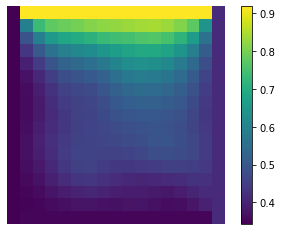

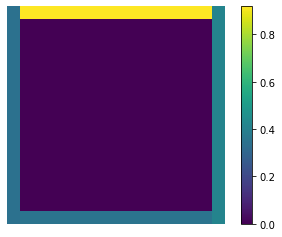

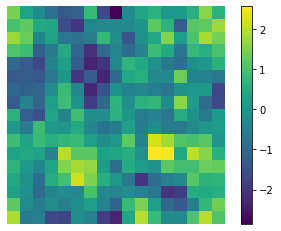

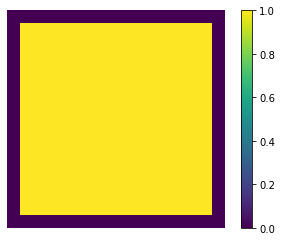

In [58]:
model_name = 'poisson_mg_kernel_17x17'

training_set = IsoPoissonDataSet('Data/IsoPoisson/poisson2d_17x17.h5')
train_dataloader = DataLoader(training_set, batch_size=64, shuffle=True)
u_train, f_train, bc_value_train, bc_index_train = next(iter(train_dataloader))

k=0
plot.plot_field(u_train[k,0])
plot.plot_field(bc_value_train[k,0])
plot.plot_field(f_train[k,0])
plot.plot_field(bc_index_train[k,0])

0 2.8947253227233887
1 2.08940052986145
2 1.6643394231796265
3 1.397360920906067
4 1.212345004081726
5 1.0757073163986206
6 0.9701918959617615
7 0.8859679102897644
8 0.816999077796936
9 0.7593618631362915
10 0.7103883028030396
11 0.6681973934173584
12 0.6314224004745483
13 0.5990447998046875
14 0.5702894330024719
15 0.5445550084114075
16 0.5213677287101746
17 0.5003489851951599
18 0.48119252920150757
19 0.4636475443840027
20 0.4475070536136627
21 0.43259844183921814
22 0.4187765419483185
23 0.40591856837272644
24 0.3939196765422821
25 0.3826901912689209
26 0.3721524775028229
27 0.3622394800186157
28 0.35289254784584045
29 0.34406042098999023
30 0.3356980085372925
31 0.32776543498039246
32 0.3202274441719055
33 0.31305259466171265
34 0.3062128722667694
35 0.299683153629303
36 0.29344093799591064
37 0.28746581077575684
38 0.2817395329475403
39 0.2762453556060791
40 0.2709682583808899
41 0.26589447259902954
42 0.2610114812850952
43 0.25630784034729004
44 0.2517729103565216
45 0.2473971396

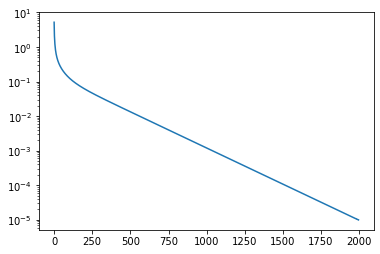

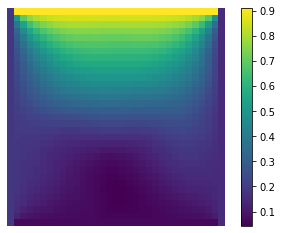

Solution from dataset:


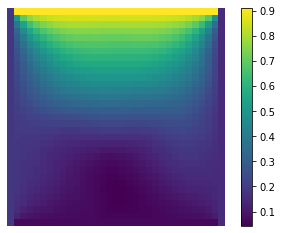

Error (dataset v.s. jacobi):


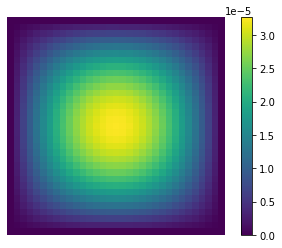

In [6]:
EPS = 1e-5
n_jac = 0
u_test = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_test = grid.fnet(f_train[k,0].reshape((1,1,n+1,n+1))) # assign the finest rhs 
grid.ResetBoundary(bc_index_train[k,0].reshape((1,1,n+1,n+1)), bc_value_train[k,0].reshape((1,1,n+1,n+1)))
u_test = grid.jac.reset_boundary(u_test)
residual = f_test-grid.Knet(u_test)
res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
res_arr = [res]
while (abs(res) > EPS):
    u_test = grid.Relax(u_test, f_test, 1)
    residual = f_test-grid.Knet(u_test)
    res = torch.sqrt(torch.sum(residual[:, :, 1:-1, 1:-1] ** 2)).item()
    res_arr.append(res)
    print(n_jac, res)
    n_jac += 1

print("Solution converges after", n_jac, "Jacobi iterations ")
plt.plot(res_arr)
plt.yscale('log')

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. jacobi):")
plot.plot_field(u_train[k,0]-u_test.detach().reshape((1,1,n+1,n+1)))

In [49]:
linear_tensor_P = torch.asarray([[1, 2, 1],
                                 [2, 4, 2],
                                 [1, 2, 1]], dtype=torch.float32) / 4.0
linear_tensor_P

tensor([[0.2500, 0.5000, 0.2500],
        [0.5000, 1.0000, 0.5000],
        [0.2500, 0.5000, 0.2500]])

In [8]:
class RestrictionNet(nn.Module):
    '''Given an initial kernel, inter-grid communication'''
    def __init__(self, tensor_R):
        super(RestrictionNet, self).__init__()
        self.n_channel = 1
        self.net = nn.Conv2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, bias=False) # restriction
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][0][i] = tensor_R
    def forward(self, x_split):
        return self.net(x_split)


class ProlongationNet(nn.Module):
    '''Given an initial P kernel'''
    def __init__(self, tensor_P):
        super(ProlongationNet, self).__init__()
        self.n_channel = 1
        self.net = nn.ConvTranspose2d(in_channels=self.n_channel,out_channels=1, kernel_size=3, stride=2, padding=1, bias=False) # interpolation
        for i in range(self.n_channel):
            self.net.state_dict()['weight'][i][0] = tensor_P
            
    def forward(self, x_split): 
        return self.net(x_split)

In [9]:
class MultiGrid(nn.Module):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, n, linear_tensor_P):
        super(MultiGrid, self).__init__()

        # Problem parameters
        self.size = 2
        self.n = n # number of grid intervals for finest grid edges
        self.L = int(np.log2(n)) # multigrid iteration
        self.solution = []
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids

        self.mse_loss = nn.MSELoss()
        
        # Inter-grid communication network models
        self.conv = RestrictionNet(linear_tensor_P)
        self.deconv = ProlongationNet(linear_tensor_P)
        
        self.conv.requires_grad_(True)
        self.deconv.requires_grad_(False)
    
    def GridDict(self):
        grids = {}
        for i in range(self.L):
            grids[i] = SingleGrid(self.size, self.n_arr[i])
        return grids        
            
    def SizeArray(self):
        n_arr = []
        for i in range(self.L):
            n_arr.append(int(self.n/(2.**i)))
        n_arr = np.array(n_arr)
        return n_arr

    def Restrict(self, rF):
        '''
        Perform restriction operation to down sample to next (coarser) level
        Note: rF has already been splitted
        '''
        rFC = self.conv(rF[:, :, 1:-1, 1:-1].clone())
        rFC = F.pad(rFC,(1,1,1,1),"constant",0) # pad the coarse-level residual with zeros
        return rFC

    def Interpolate(self, eFC):
        '''
        Perform interpolation and upsample to previous (finer) level 
        Note: eFC has already been splitted
        '''
        eF = self.deconv(eFC.clone())
        return eF 

    def loss(self, uk, k):
        "Compute the loss after k iterations, uk is current solution"
        #err = u.clone() - u_star
        #return torch.mean(torch.norm(err, dim=(2,3)))
        #return self.mse_loss(u, u_star)
        resk = self.f - self.grids[0].Knet(uk)
        res0 = self.f - self.grids[0].Knet(self.u0)
        return torch.mean(torch.pow(torch.norm(resk[:, :, 1:-1, 1:-1].clone(), dim=(2,3))/torch.norm(res0[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).detach(), 1.0/k))

    def forward(self, u0, F, bc_idx, bc_value, k):
        '''Input is initial solution u0, RHS field F, boundary value B, iteration number k'''
        self.f = self.grids[0].fnet(F) # assign the finest rhs 
        self.grids[0].ResetBoundary(bc_idx, bc_value) # reset the boundary of finest grid
        self.u0 = self.grids[0].jac.reset_boundary(u0)
        U = self.u0.clone()
        
        for i in range(k-1):
            U = self.iterate(U, self.f).detach()
        return self.iterate(U, self.f)

    def iterate(self, x, f):
        '''Input x is the initial solution on the finest grid'''
        n_batches = x.shape[0]
        n_relax = 1 # number of relaxations
        self.grids[0].v = x
        self.grids[0].f = f
        self.grids[0].v = self.grids[0].Relax(self.grids[0].v, self.grids[0].f, n_relax)

        for j in range(0, self.L-1):
            rF = self.grids[j].f-self.grids[j].Knet(self.grids[j].v)
            rF = self.grids[j].Knet.split_x(rF)
            self.grids[j+1].f = self.Restrict(rF)
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False)
            self.grids[j+1].v = self.grids[j+1].Relax(self.grids[j+1].v, self.grids[j+1].f, n_relax)

        self.grids[self.L-1].v = self.grids[self.L-1].Relax(self.grids[self.L-1].v, self.grids[self.L-1].f, n_relax)

        for j in range(self.L-2,-1,-1):
            eFC = self.grids[j+1].Knet.split_x(self.grids[j+1].v)
            eF_delta = self.Interpolate(eFC)
            self.grids[j].v = self.grids[j].v + eF_delta
            self.grids[j].v = self.grids[j].Relax(self.grids[j].v, self.grids[j].f, n_relax)

            # zero out the previous level solution
            self.grids[j+1].v = torch.zeros((n_batches,1,self.n_arr[j+1]+1,self.n_arr[j+1]+1), dtype=torch.float32, requires_grad=False) 

        return self.grids[0].v 

In [10]:
def random_sampling(x):
    u = torch.randn_like(x)
    return u

In [29]:
model = MultiGrid(n, linear_tensor_P+0.5*torch.rand((3,3)))
model_linear = MultiGrid(n, linear_tensor_P)

0 5.193249225616455
1 1.1326112747192383
2 0.27109450101852417
3 0.06555454432964325
4 0.01595371402800083
5 0.003902275813743472
6 0.0009584384970366955
7 0.00023628791677765548
8 5.849431181559339e-05
9 1.4623525203205645e-05
10 3.771002866415074e-06
Solution converges after 10 multi-grid iterations 


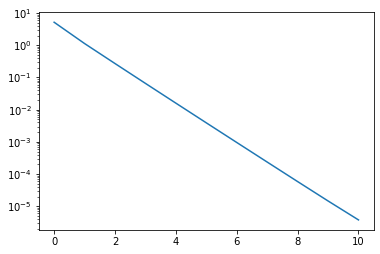

Multigrid solution:


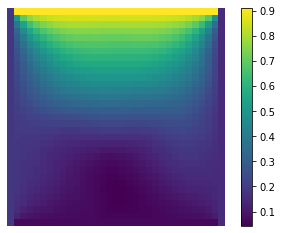

Jacobi solution:


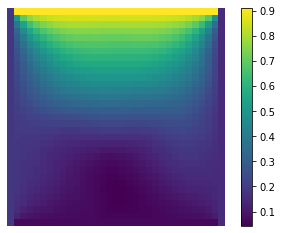

Solution from dataset:


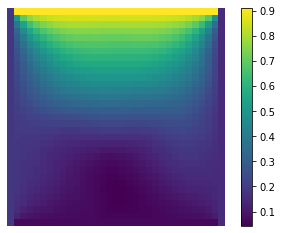

Error (dataset v.s. mg):


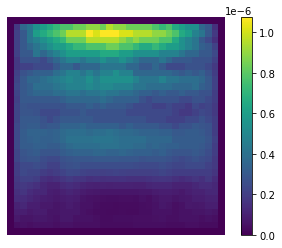

In [12]:
n_multigrid = 0
u_mg = torch.zeros((1, 1, n+1, n+1), requires_grad=False, dtype=torch.float32)
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model_linear(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
err_occured = False
residual = model_linear.f-model_linear.grids[0].Knet(model_linear.u0)
res = torch.linalg.matrix_norm(residual[:, :, 1:-1, 1:-1].clone()).item()
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model_linear.iterate(u_mg, model_linear.f)
    residual = model_linear.f-model_linear.grids[0].Knet(u_mg)
    res = torch.linalg.matrix_norm(residual[:, :, 1:-1, 1:-1].clone()).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Jacobi solution:")
plot.plot_field(u_test.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [30]:
model_dir = 'Model/iso_poisson'
if not os.path.exists(model_dir):
    os.makedirs(model_dir)

optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
mlist = list(model.parameters())
print('Restriction kernel:', mlist[0][0][0])
print('Restriction kernel shape:', mlist[0].shape)
print('Interpolation kernel:', mlist[1][0][0])
print('Interpolation kernel shape:', mlist[1].shape)

Restriction kernel: tensor([[0.6008, 0.9159, 0.4965],
        [0.8875, 1.2590, 0.5999],
        [0.3426, 0.9588, 0.4514]], grad_fn=<SelectBackward0>)
Restriction kernel shape: torch.Size([1, 1, 3, 3])
Interpolation kernel: tensor([[0.6008, 0.9159, 0.4965],
        [0.8875, 1.2590, 0.5999],
        [0.3426, 0.9588, 0.4514]])
Interpolation kernel shape: torch.Size([1, 1, 3, 3])


In [14]:
def copy_kernels(para_list):
    '''Copy the values of R kernels to P kernels'''
    para_list[1][0,:] = para_list[0][:,0].detach()

In [15]:
def train_one_epoch():
    running_loss = 0.
    for i, data in enumerate(train_dataloader):
        u_train, f_train, bc_value_train, bc_index_train = data
        
        optimizer.zero_grad() # zero the gradients for every batch
        k = random.randint(1,10)
        u0 = random_sampling(f_train)

        u_out = model(u0, f_train, bc_index_train, bc_value_train, k)
        loss_i = model.loss(u_out, k)
        
        loss_i.backward()
        para_list = list(model.parameters())
        optimizer.step()
        copy_kernels(para_list) # update the P kernels
        
        running_loss += loss_i.item()
    
    last_loss = running_loss/(i+1)
    return last_loss, para_list[0][0,0].data

In [16]:
num_epoch = 1000
best_vloss = 1_000_000.

loss_train = torch.zeros((num_epoch, 1))
kernel_train = torch.zeros((num_epoch, 3, 3))
for epoch in range(num_epoch):
    model.train(True)
    avg_loss, kernel_i = train_one_epoch()
    print(epoch, avg_loss)
    
    # Track best performance, and save the model's state
    mpath = os.path.join(model_dir,model_name+'.pth')
    torch.save(model.state_dict(), mpath)
    loss_train[epoch] = avg_loss
    kernel_train[epoch] = kernel_i.detach().clone()


0 3.6287061874754727
1 2.9377259593456984
2 3.024959795176983
3 1.8213234287686646
4 1.8141405917704105
5 1.0628166166134179
6 1.162124696187675
7 1.0017973557114601
8 1.0343070114031434
9 0.9770437777042389
10 0.6905040740966797
11 0.7950378190726042
12 0.4477752479724586
13 0.3823026749305427
14 0.35647897608578205
15 0.3280673655681312
16 0.41479373164474964
17 0.30236223665997386
18 0.2854493409395218
19 0.2742180749773979
20 0.24004406528547406
21 0.19714820617809892
22 0.17642246931791306
23 0.17047952068969607
24 0.1652148300781846
25 0.16307426197454333
26 0.1746431216597557
27 0.16510247252881527
28 0.15014910465106368
29 0.18124127620831132
30 0.1705446862615645
31 0.1581792663782835
32 0.16404169565066695
33 0.16897784220054746
34 0.15567518677562475
35 0.15114222234115005
36 0.19140247954055667
37 0.17144056456163526
38 0.1633381606079638
39 0.18157633487135172
40 0.14817658392712474
41 0.1766563574783504
42 0.16762025468051434
43 0.1604880471713841
44 0.1637711925432086
45

Average q:  tensor(0.1565) , STD:  tensor(0.0099)


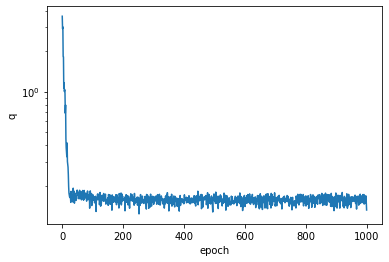

In [17]:
plt.plot(loss_train)
plt.ylabel('q')
plt.yscale('log')
plt.xlabel('epoch')
print("Average q: ", torch.mean(loss_train[-100:]), ", STD: ", torch.std(loss_train[-100:]))

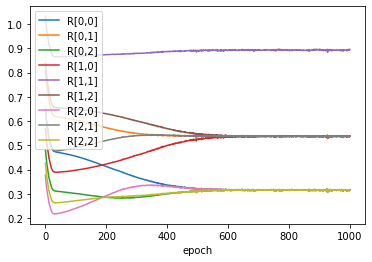

In [18]:
plt.plot(kernel_train[:,0,0], label="R[0,0]")
plt.plot(kernel_train[:,0,1], label="R[0,1]")
plt.plot(kernel_train[:,0,2], label="R[0,2]")
plt.plot(kernel_train[:,1,0], label="R[1,0]")
plt.plot(kernel_train[:,1,1], label="R[1,1]")
plt.plot(kernel_train[:,1,2], label="R[1,2]")
plt.plot(kernel_train[:,2,0], label="R[2,0]")
plt.plot(kernel_train[:,2,1], label="R[2,1]")
plt.plot(kernel_train[:,2,2], label="R[2,2]")
plt.xlabel('epoch')
plt.legend()

In [19]:
# save the list
torch.save(loss_train, os.path.join(model_dir,model_name+'.pt'))
torch.save(kernel_train, os.path.join(model_dir,model_name+'-kernels.pt'))

In [43]:
# import the learned model
#model_name = 'poisson_mg_kernel_17x17'
Ps = torch.load(os.path.join(model_dir,model_name+'-kernels.pt'))
P = torch.mean(Ps[-100:,:,:],dim=0)
print('Learned Restriction/Prolongation kernel:')
print(P)

Learned Restriction/Prolongation kernel:
tensor([[0.3006, 0.5301, 0.3003],
        [0.5303, 0.9166, 0.5297],
        [0.3011, 0.5301, 0.3007]])


In [59]:
P = linear_tensor_P.clone()

In [51]:
def compute_q(res_arr):
    return res_arr[-1]/res_arr[-2]

0 44.375606536865234
1 3.268773317337036
2 0.5480424165725708
3 0.10927262902259827
4 0.023129355162382126
5 0.0050493828020989895
6 0.0011235530255362391
7 0.00025323161389678717
8 5.7638117141323164e-05
9 1.3232944183982909e-05
10 3.0974495075497543e-06
Solution converges after 10 multi-grid iterations 


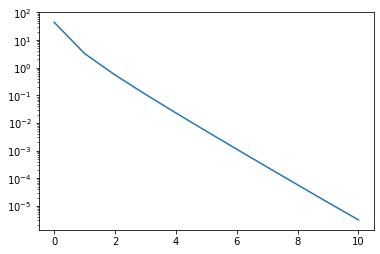

Multigrid solution:


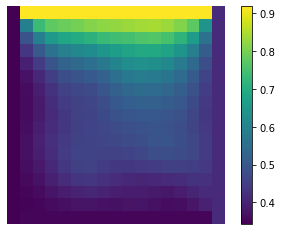

Solution from dataset:


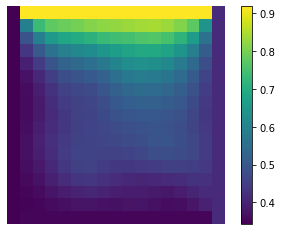

Error (dataset v.s. mg):


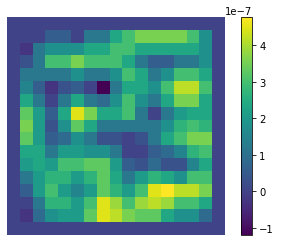

In [60]:
EPS = 1e-5
model = MultiGrid(n, P) # create a new model
n_multigrid = 0
f_mg = f_train[k,0].reshape((1,1,n+1,n+1))
u_mg = random_sampling(f_mg)
bc_idx_mg = bc_index_train[k,0].reshape((1,1,n+1,n+1))
bc_value_mg = bc_value_train[k,0].reshape((1,1,n+1,n+1))
model(u_mg, f_mg, bc_idx_mg, bc_value_mg, 1)
residual = model.f-model.grids[0].Knet(model.u0)
res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
err_occured = False
res_arr = [res]
print(n_multigrid, res)
while (abs(res) > EPS):
    u_mg = model.iterate(u_mg, model.f)
    residual = model.f-model.grids[0].Knet(u_mg)
    res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
    res_arr.append(res)
    n_multigrid += 1
    print(n_multigrid, res)

    if(res == torch.inf or math.isnan(res)):
        err_occured = True
        break

if(err_occured):
    print("The iteration doesn't converge!")
else:
    print("Solution converges after", n_multigrid, "multi-grid iterations ")
plt.plot(res_arr)
plt.yscale('log')
plt.show()

print("Multigrid solution:")
plot.plot_field(u_mg.detach())

print("Solution from dataset:")
plot.plot_field(u_train[k,0])

print("Error (dataset v.s. mg):")
plot.plot_field(u_train[k,0]-u_mg.detach().reshape((1,1,n+1,n+1)))

In [61]:
print("q is: ", compute_q(res_arr))
print("q hat is: " + str(float(model.loss(u_mg, len(res_arr)-1).detach())))

q is:  0.23407107779528702
q hat is: 0.1924801766872406


In [62]:
# Test the multigrid iteration
class mgTest(MultiGrid):
    '''Define the multigrid problem for 2D, n is the finest grid size'''
    def __init__(self, inter_model, n = 64):
        super(mgTest, self).__init__(n, linear_tensor_P)

        self.size = 2
        self.n = n # total number of grids for finest grid
        self.L = int(np.log2(n)) # number of levels for V-cycle multigrid
        self.x = np.linspace(-1,1,n+1, dtype=np.float32) # grid number is n+1
        self.y = np.linspace(-1,1,n+1, dtype=np.float32)
        self.xx, self.yy = np.meshgrid(self.x, self.y, indexing='xy')
        self.solution = []

        self.conv = inter_model.conv
        self.deconv = inter_model.deconv
        self.conv.requires_grad_(False)
        self.deconv.requires_grad_(False)
        
        self.n_arr = self.SizeArray() # array to store grid size for each level
        self.grids = self.GridDict() # dictionary of structure grids
        
        ff = np.ones_like(self.xx)
        self.grids[0].f = self.grids[0].fnet(torch.from_numpy(ff.reshape(1,1,n+1,n+1))) # assign the finest right hand side with the original rhs
    
    def solve(self):
        '''Return error and residual array'''
        EPS = 5e-5
        n_Vcycle = 0
        self.grids[0].v = torch.zeros((1, 1, self.n+1, self.n+1), requires_grad=False, dtype=torch.float32)
        e_Vcycle, res = 1, 1
        e_arr_Vcycle = [e_Vcycle]
        res_arr_Vcycle = [res]
        err_occured = False
        while (res > EPS):
            u_prev = self.grids[0].v 
            self.grids[0].v = self.iterate(self.grids[0].v,self.grids[0].f)
            e_Vcycle = torch.sqrt(torch.sum((self.grids[0].v - u_prev) ** 2)).item() / torch.sqrt(torch.sum((self.grids[0].v) ** 2)).item()
            e_arr_Vcycle.append(e_Vcycle)
            residual = self.grids[0].f-self.grids[0].Knet(self.grids[0].v)
            res = torch.norm(residual[:, :, 1:-1, 1:-1].clone(), dim=(2,3)).item()
            res_arr_Vcycle.append(res)
            print(e_Vcycle, res)
            n_Vcycle += 1
            if(res == torch.inf or math.isnan(res)):
                err_occured = True
                break

        if(err_occured):
            print("The iteration doesn't converge!")
        else:
            print("Solution converges after", n_Vcycle, "V-cycle iterations with relative error of", e_Vcycle)
        return e_arr_Vcycle, res_arr_Vcycle

1.0 0.006256271153688431
0.132474589890413 0.0014408191200345755
0.020360189580170832 0.00035932185710407794
0.0033012010899671424 9.320205572294071e-05
0.0005632320474166205 2.4709306671866216e-05
Solution converges after 5 V-cycle iterations with relative error of 0.0005632320474166205


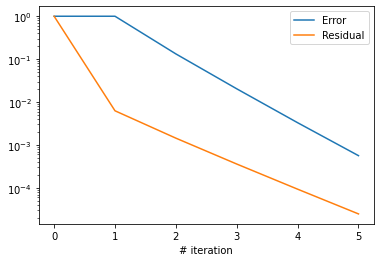

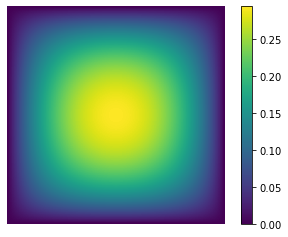

In [71]:
# Multigrid implementation
n = 2**7
model_mg = MultiGrid(n, P) # create a new model
prob_mg = mgTest(model_mg, n)

e_arr_Vcycle, res_arr_Vcycle = prob_mg.solve()

plt.plot(e_arr_Vcycle, label='Error')
plt.plot(res_arr_Vcycle, label='Residual')
plt.yscale('log')
plt.xlabel('# iteration')
#plt.ylabel('Error')
plt.legend()

plot.plot_field(prob_mg.grids[0].v.detach())

In [72]:
print("q is: ", compute_q(res_arr_Vcycle))

q is:  0.26511546853986695
